<a href="https://colab.research.google.com/github/irentala/fake-profile-detection-transformer/blob/master/KMNIST_Data_convolutional_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network

Build a convolutional neural network with TensorFlow v2.

This example is using a low-level approach to better understand all mechanics behind building convolutional neural networks and the training process.

- Original Author: Aymeric Damien
- Project: https://github.com/aymericdamien/TensorFlow-Examples/
- Experimented By: Indrani Rentala
   - Using KMNIST dataset  
   - Multiple optimizers: Adam, Stochastic gradient descent

## CNN Overview

![CNN](http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png)

##  KMNIST dataset
KMNIST Dataset:
The Kuzushiji-MNIST (KMNIST) dataset consists of handwritten Japanese characters (cursive Hiragana), similar to MNIST.
It contains 10 classes, each representing a different character.
Each image is 28x28 pixels in grayscale, making it suitable for adapting models designed for MNIST.

In [30]:
# Cell 1: Import Libraries
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np
import tensorflow_datasets as tfds  # Import TensorFlow Datasets to load KMNIST
import matplotlib.pyplot as plt


In [31]:
# Cell 2: Load KMNIST Dataset and Set Parameters

# Dataset parameters
num_classes = 10  # KMNIST has 10 classes (0-9, representing different characters).

# Training parameters
learning_rate = 0.001
training_steps = 200
batch_size = 128
display_step = 10

# Load KMNIST dataset.
(ds_train, ds_test), ds_info = tfds.load(
    'kmnist', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True
)

# Preprocessing function to normalize images.
def preprocess(image, label):
    # Normalize images from [0, 255] to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Apply preprocessing to the datasets.
ds_train = ds_train.map(preprocess).shuffle(5000).batch(batch_size).prefetch(1)
ds_test = ds_test.map(preprocess).batch(batch_size).prefetch(1)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/kmnist/incomplete.OBMTA4_3.0.1/kmnist-train.tfrecord*...:   0%|          |…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/kmnist/incomplete.OBMTA4_3.0.1/kmnist-test.tfrecord*...:   0%|          | …

Dataset kmnist downloaded and prepared to /root/tensorflow_datasets/kmnist/3.0.1. Subsequent calls will reuse this data.


In [32]:
# Cell 3: Create TF Model
class ConvNet(Model):
    # Set layers.
    def __init__(self):
        super(ConvNet, self).__init__()
        # Convolution Layer with 32 filters and a kernel size of 5.
        self.conv1 = layers.Conv2D(32, kernel_size=5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with kernel size of 2 and strides of 2.
        self.maxpool1 = layers.MaxPool2D(2, strides=2)

        # Convolution Layer with 64 filters and a kernel size of 3.
        self.conv2 = layers.Conv2D(64, kernel_size=3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with kernel size of 2 and strides of 2.
        self.maxpool2 = layers.MaxPool2D(2, strides=2)

        # Flatten the data to a 1-D vector for the fully connected layer.
        self.flatten = layers.Flatten()

        # Fully connected layer.
        self.fc1 = layers.Dense(1024)
        # Apply Dropout (if is_training is False, dropout is not applied).
        self.dropout = layers.Dropout(rate=0.5)

        # Output layer, class prediction.
        self.out = layers.Dense(num_classes)

    # Set forward pass.
    def call(self, x, is_training=False):
        x = tf.reshape(x, [-1, 28, 28, 1])
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x, training=is_training)
        x = self.out(x)
        if not is_training:
            # tf cross entropy expects logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x



In [33]:
# Cell 4: Build Neural Network Model
conv_net = ConvNet()



In [34]:
# Cell 5: Define Cross-Entropy Loss and Accuracy Metric
# Cross-Entropy Loss.
# Note that this will apply 'softmax' to the logits.
def cross_entropy_loss(x, y):
    # Convert labels to int 64 for tf cross-entropy function.
    y = tf.cast(y, tf.int64)
    # Apply softmax to logits and compute cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    # Average loss across the batch.
    return tf.reduce_mean(loss)

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)



In [40]:
# Cell 6: Define Optimizers
# Stochastic gradient descent optimizer.
optimizer_adam = tf.optimizers.Adam(learning_rate)
optimizer_sgd = tf.optimizers.SGD(learning_rate)


In [41]:
# Cell 7: Optimization Process with Multiple Optimizers
def run_optimization(x, y, use_adam=True):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        # Forward pass.
        pred = conv_net(x, is_training=True)
        # Compute loss.
        loss = cross_entropy_loss(pred, y)

    # Variables to update, i.e. trainable variables.
    trainable_variables = conv_net.trainable_variables

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)

    # Update W and b following gradients.
    if use_adam:
        optimizer_adam.apply_gradients(zip(gradients, trainable_variables))
    else:
        optimizer_sgd.apply_gradients(zip(gradients, trainable_variables))

In [42]:
# Cell 8: Run Training Loop
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(ds_train.take(training_steps), 1):
    # Alternate between Adam and SGD optimizers.
    use_adam = step % 2 == 0
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y, use_adam=use_adam)

    if step % display_step == 0:
        pred = conv_net(batch_x)
        loss = cross_entropy_loss(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 10, loss: 1.543020, accuracy: 0.945312
step: 20, loss: 1.553241, accuracy: 0.937500
step: 30, loss: 1.580164, accuracy: 0.945312
step: 40, loss: 1.577042, accuracy: 0.906250
step: 50, loss: 1.541957, accuracy: 0.953125
step: 60, loss: 1.517787, accuracy: 0.984375
step: 70, loss: 1.559288, accuracy: 0.929688
step: 80, loss: 1.521637, accuracy: 0.968750
step: 90, loss: 1.573801, accuracy: 0.914062
step: 100, loss: 1.529412, accuracy: 0.953125
step: 110, loss: 1.537497, accuracy: 0.960938
step: 120, loss: 1.540305, accuracy: 0.945312
step: 130, loss: 1.526036, accuracy: 0.968750
step: 140, loss: 1.536643, accuracy: 0.953125
step: 150, loss: 1.551710, accuracy: 0.929688
step: 160, loss: 1.513338, accuracy: 0.984375
step: 170, loss: 1.526218, accuracy: 0.953125
step: 180, loss: 1.530746, accuracy: 0.960938
step: 190, loss: 1.551467, accuracy: 0.953125
step: 200, loss: 1.533322, accuracy: 0.960938


In [43]:
# Cell 9: Test the Model
# Test model on validation set.
for batch_x, batch_y in ds_test:
    pred = conv_net(batch_x)
    test_acc = accuracy(pred, batch_y)
print("Test Accuracy: %f" % test_acc)

Test Accuracy: 0.937500


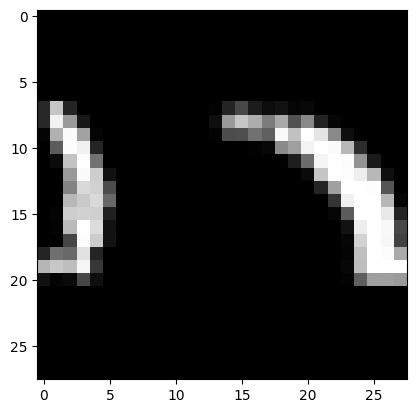

Model prediction: 5


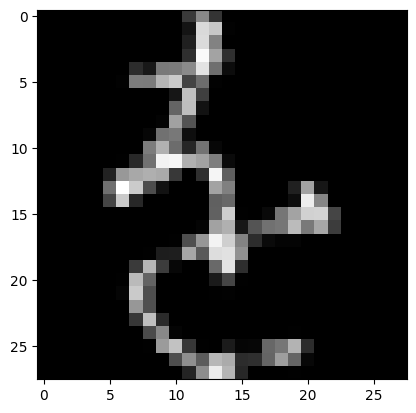

Model prediction: 9


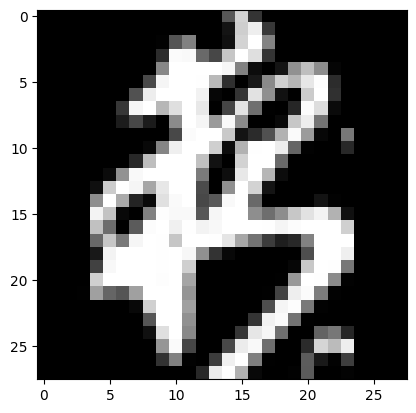

Model prediction: 7


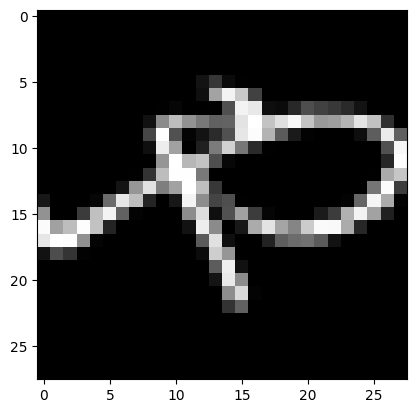

Model prediction: 7


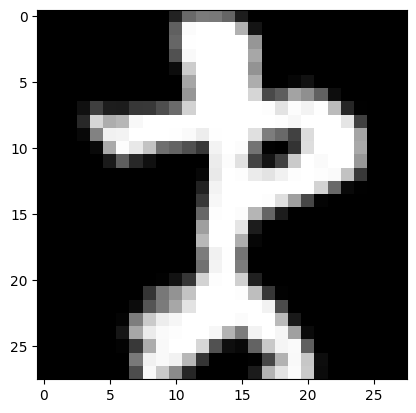

Model prediction: 6


In [44]:
# Cell 10: Visualize Predictions
# Predict 5 images from validation set.
n_images = 5
test_images, test_labels = next(iter(ds_test.take(1)))
test_images, test_labels = test_images[:n_images], test_labels[:n_images]
predictions = conv_net(test_images)

# Display image and model prediction.
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction: %i" % np.argmax(predictions.numpy()[i]))